In [1]:
# Import libraries to use logistic regression
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


In [2]:
credit_data = pd.read_csv('csv_files/credit.csv')

In [3]:
credit_data = credit_data.drop(columns=['Unnamed: 0'])

In [4]:
# Run logistic regression using WC/TA, RE/TA, EBIT/TA, ME/TL, S/TA with 50% benchmark
X = credit_data[['WC/TA', 'RE/TA', 'EBIT/TA', 'ME/TL', 'S/TA']]
y = credit_data['Default']

weight_for_0 = 0.5  # Weight for the non-default class
weight_for_1 = 0.5  # Weight for the default class

class_weights = {0: weight_for_0, 1: weight_for_1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

logistic = linear_model.LogisticRegression(class_weight=class_weights)
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_train)


In [5]:
print('R2 Score:', r2_score(y_train, y_pred))
print('Accuracy Score:', accuracy_score(y_train, y_pred))
print('Confusion Matrix:', confusion_matrix(y_train, y_pred))

R2 Score: -0.06891403426056897
Accuracy Score: 0.9088191330343797
Confusion Matrix: [[600   6]
 [ 55   8]]


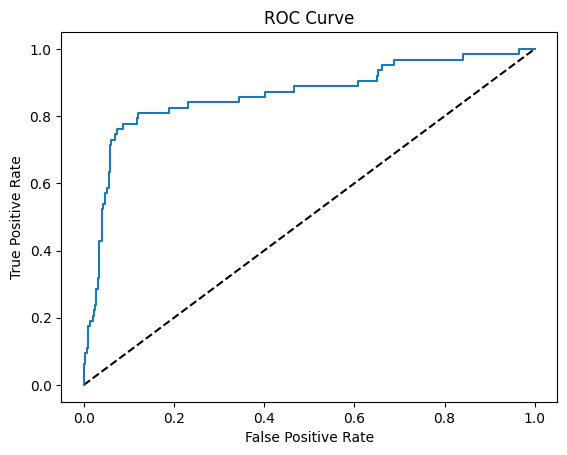

ROC AUC Score: 0.8632196552988631


In [6]:
# Create ROC Curve
y_pred_proba = logistic.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print ROC Curve Statistics
print('ROC AUC Score:', roc_auc_score(y_train, y_pred_proba))

Test Truth Table
Accuracy Score: 0.9066666666666666
Confusion Matrix: [[67  1]
 [ 6  1]]


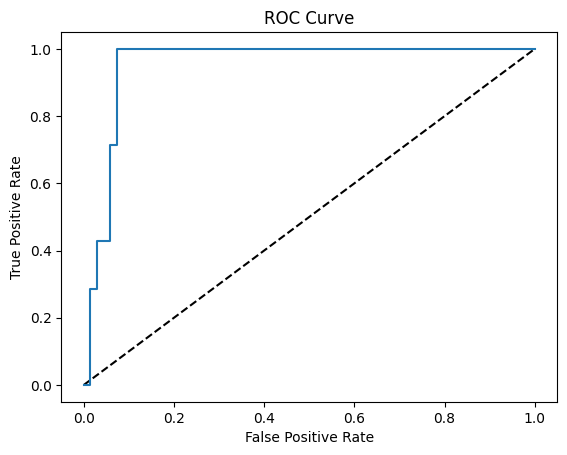

ROC AUC Score: 0.9537815126050421


In [7]:
y_pred_test = logistic.predict(X_test)

# Calculate truth table for test
print('Test Truth Table')
print('Accuracy Score:', accuracy_score(y_test, y_pred_test))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred_test))

# Create ROC Curve for test
y_pred_proba = logistic.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print ROC Curve Statistics
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))


In [23]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

# Initialize lists to store predictions and actual labels
predictions = []
true_labels = []

# Iterate through each training and testing set from LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the logistic regression model
    logistic = linear_model.LogisticRegression(class_weight=class_weights)
    logistic.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = logistic.predict(X_test)

    # Store the predictions and true labels
    predictions.append(y_pred)
    true_labels.append(y_test.values[0])

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
y_pred_proba = logistic.predict_proba(X)[:,1]
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.907258064516129
Confusion Matrix:
[[667   7]
 [ 62   8]]
ROC AUC Score: 0.8739296311996609


In [25]:
from sklearn.model_selection import KFold

# Define the number of folds
k = 10

# Initialize lists to store predictions and actual labels
predictions = []
true_labels = []

# Initialize KFold
kf = KFold(n_splits=k)

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the logistic regression model
    logistic = linear_model.LogisticRegression(class_weight=class_weights)
    logistic.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = logistic.predict(X_test)

    # Store the predictions and true labels
    predictions.extend(y_pred)
    true_labels.extend(y_test)

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate ROC AUC score
y_pred_proba = logistic.predict_proba(X)[:,1]
roc_auc = roc_auc_score(y, y_pred_proba)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8978494623655914
Confusion Matrix:
[[667   7]
 [ 69   1]]
ROC AUC Score: 0.8763459092835947


In [27]:
import itertools
import pandas as pd
import statsmodels.api as sm

# Assuming you have imported your data and defined X and y as mentioned in your question

# Function to perform Best Subset Regression
def best_subset_regression(X, y, criterion='aic'):
    results = []
    for k in range(1, len(X.columns) + 1):
        subsets = itertools.combinations(X.columns, k)
        for subset in subsets:
            model = sm.Logit(y, sm.add_constant(X[list(subset)])).fit(disp=0)
            if criterion == 'aic':
                results.append((model, model.aic, subset))
            elif criterion == 'bic':
                results.append((model, model.bic, subset))
    
    # Select the model with the minimum AIC/BIC
    best_model = min(results, key=lambda x: x[1])
    return best_model

# Perform Best Subset Regression using BIC
best_model_bic = best_subset_regression(X, y, criterion='bic')
print("\nBest Subset Regression using BIC:")
print("BIC:", best_model_bic[1])
print("Variables:", best_model_bic[2])
print(best_model_bic[0].summary())



Best Subset Regression using BIC:
BIC: 365.72154205076663
Variables: ('RE/TA', 'ME/TL')
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                  744
Model:                          Logit   Df Residuals:                      741
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 May 2024   Pseudo R-squ.:                  0.2547
Time:                        21:03:48   Log-Likelihood:                -172.94
converged:                       True   LL-Null:                       -232.05
Covariance Type:            nonrobust   LLR p-value:                 2.145e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8320      0.235     -3.543      0.000      -1.292      -0.372
RE/TA         -1.1031      0.288     -3.82

In [29]:
from sklearn.linear_model import Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Fit Ridge regression
ridge = Ridge()
ridge_params = {'alpha': np.logspace(-4, 4, 100)}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=10)
ridge_cv.fit(X_train, y_train)
ridge_best_alpha = ridge_cv.best_params_['alpha']
ridge_best_model = Ridge(alpha=ridge_best_alpha)
ridge_best_model.fit(X_train, y_train)
ridge_pred = ridge_best_model.predict(X_train)
ridge_mse = mean_squared_error(y_train, ridge_pred)

# Fit LASSO regression
lasso = Lasso()
lasso_params = {'alpha': np.logspace(-4, 4, 100)}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=10)
lasso_cv.fit(X_train, y_train)
lasso_best_alpha = lasso_cv.best_params_['alpha']
lasso_best_model = Lasso(alpha=lasso_best_alpha)
lasso_best_model.fit(X_train, y_train)
lasso_pred = lasso_best_model.predict(X_train)
lasso_mse = mean_squared_error(y_train, lasso_pred)

# Fit Elastic Net regression
elastic_net = ElasticNetCV(cv=10, random_state=42)
elastic_net.fit(X_train, y_train)
elastic_net_alpha = elastic_net.alpha_
elastic_net_l1_ratio = elastic_net.l1_ratio_
elastic_net_best_model = ElasticNet(alpha=elastic_net_alpha, l1_ratio=elastic_net_l1_ratio)
elastic_net_best_model.fit(X_train, y_train)
elastic_net_pred = elastic_net_best_model.predict(X_train)
elastic_net_mse = mean_squared_error(y_train, elastic_net_pred)

ridge_best_alpha, ridge_mse, lasso_best_alpha, lasso_mse, elastic_net_alpha, elastic_net_l1_ratio, elastic_net_mse


(0.298364724028334,
 0.03918516289102631,
 0.0003053855508833416,
 0.039183065317384407,
 0.0003472237736659053,
 0.5,
 0.03917508780589427)